## GROUP 1 - Python - PART 1
* DEL CARPIO CUENCA, GABRIEL SEBASTIAN
* ESPINOSA CALDERON, MAURICIO GUSTAVO
* JAIME MARTINEZ, KEVIN OSWALDO
* MELLIZO ANTAZU, MILAGROS ESTEFANY
* QUISPE ROBLADILLO, ALMENDRA VALERIA

In [65]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import numpy as np
import pandas as pd
import patsy
import os
import warnings
warnings.simplefilter('ignore')

# Part 1: Double Lasso

1. Consider the US census data from the year 2015 to analyse the effect of college graduate (clg) status and it’s interaction effects with gender (sex), location (mw, so,we, ne) and both on wage jointly. All other variables denote some other socio-economic characteristics, e.g. marital status, occupation, and experience.

In [66]:
data = pd.read_csv('../../../../data/wage2015_subsample_inference.csv')
data = data.drop('rownames',axis=1)
list(data.columns)

['wage',
 'lwage',
 'sex',
 'shs',
 'hsg',
 'scl',
 'clg',
 'ad',
 'mw',
 'so',
 'we',
 'ne',
 'exp1',
 'exp2',
 'exp3',
 'exp4',
 'occ',
 'occ2',
 'ind',
 'ind2']

* Generate the dataset with all the two-way interactions between variables. Make sure that the categorical variables are transformed to dummies properly. Also, note that the resulting dataset contains the treatment and it’s interactions with the other variables of interest, so you don’t need to generate them separately. (2 pts)

In [67]:
# Normalization of continuous variables:
continuous = ['exp1', 'exp2', 'exp3', 'exp4']
data[continuous] = StandardScaler().fit_transform(data[continuous])
list(data.columns)

['wage',
 'lwage',
 'sex',
 'shs',
 'hsg',
 'scl',
 'clg',
 'ad',
 'mw',
 'so',
 'we',
 'ne',
 'exp1',
 'exp2',
 'exp3',
 'exp4',
 'occ',
 'occ2',
 'ind',
 'ind2']

In [68]:
Y = np.log(data['lwage']).values
Z = data.drop(['wage', 'lwage'], axis=1)
Z.columns

Index(['sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so', 'we', 'ne', 'exp1',
       'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind', 'ind2'],
      dtype='object')

In [69]:
 # Interactions
Zcontrols = patsy.dmatrix('0 + (sex + mw + so + we + ne + exp1 + exp2 + exp3 + exp4 + ' + \
          ' + C(occ2) + C(ind2) )**2', Z, return_type='dataframe')  
Zcontrols = Zcontrols - Zcontrols.mean(axis=0)  # Resta la media de cada columna para centrar la matriz en torno a su media, las var tienen media cero y es mejor para el modelo


In [70]:
Zhet = patsy.dmatrix('0 + (sex+mw+so+we+ne+exp1+exp2+exp3+exp4)',
                     Z, return_type='dataframe')
Zhet = Zhet - Zhet.mean(axis=0)

In [71]:
Zhet['clg'] = Z['clg']
Zinteractions = patsy.dmatrix('0 + clg + clg * (sex+mw+so+we+ne)',
                              Zhet, return_type='dataframe')
interaction_cols = [c for c in Zinteractions.columns if c.startswith('clg')]

In [72]:
X = pd.concat([Zinteractions, Zcontrols], axis=1)
X.shape

(5150, 887)

* Use the double lasso technique to find the effect of the treatment and it’s relevant interactions on
the wage. To tune the penalization parameter in the lasso step, cross-validate it. (4 pts)

In [73]:
!git clone https://github.com/maxhuppertz/hdmpy.git

fatal: destination path 'hdmpy' already exists and is not an empty directory.


In [74]:
import sys
sys.path.insert(1, "./hdmpy")

In [75]:
# We wrap the package so that it has the familiar sklearn API
import hdmpy
from sklearn.base import BaseEstimator

class RLasso(BaseEstimator):

    def __init__(self, *, post=True):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    def predict(self, X):
        return np.array(X) @ np.array(self.rlasso_.est['beta']).flatten() + np.array(self.rlasso_.est['intercept'])


def lasso_model():
    return RLasso(post=False)

In [76]:
alpha = {}
res_y, res_D, epsilon = {}, {}, {}
for c in interaction_cols:
    print(f"Double Lasso for target variable {c}")
    D = X[c].values
    W = X.drop([c], axis=1)
    res_y[c] = Y - lasso_model().fit(W, Y).predict(W)
    res_D[c] = D - lasso_model().fit(W, D).predict(W)
    final = LinearRegression(fit_intercept=False).fit(res_D[c].reshape(-1, 1), res_y[c])
    epsilon[c] = res_y[c] - final.predict(res_D[c].reshape(-1, 1))
    alpha[c] = [final.coef_[0]]

Double Lasso for target variable clg
Double Lasso for target variable clg:sex
Double Lasso for target variable clg:mw
Double Lasso for target variable clg:so
Double Lasso for target variable clg:we
Double Lasso for target variable clg:ne


In [77]:
# Calculate the covariance matrix of the estimated parameters
V = np.zeros((len(interaction_cols), len(interaction_cols)))
for it, c in enumerate(interaction_cols):
    Jc = np.mean(res_D[c]**2)
    for itp, cp in enumerate(interaction_cols):
        Jcp = np.mean(res_D[cp]**2)
        Sigma = np.mean(res_D[c] * epsilon[c] * epsilon[cp] * res_D[cp])
        V[it, itp] = Sigma / (Jc * Jcp)

In [78]:
# Calculate standard errors for each parameter
n = X.shape[0]
for it, c in enumerate(interaction_cols):
    alpha[c] += [np.sqrt(V[it, it] / n)]

# put all in a dataframe
data_final = pd.DataFrame.from_dict(alpha, orient='index', columns=['point', 'stderr'])

* Report a summary of the estimation of the parameters of interest. (2 pts)

In [79]:
# Calculate and pointwise p-value
summary = pd.DataFrame()
summary['Estimate'] = data_final['point']
summary['Std. Error'] = data_final['stderr']
summary['p-value'] = norm.sf(np.abs(data_final['point'] / data_final['stderr']), loc=0, scale=1) * 2
summary['ci_lower'] = data_final['point'] - 1.96 * data_final['stderr']
summary['ci_upper'] = data_final['point'] + 1.96 * data_final['stderr']
summary

,Estimate,Std. Error,p-value,ci_lower,ci_upper
clg,0.053009,0.005435,1.780004e-22,0.042357,0.063662
clg:sex,0.002929,0.010344,7.770239e-01,-0.017344,0.023203
clg:mw,-1248.819763,301.550262,3.452947e-05,-1839.858276,-657.781250
clg:so,-54.925948,245.998298,8.233193e-01,-537.082612,427.230716
clg:we,-383.695244,607.146423,5.274098e-01,-1573.702233,806.311745
clg:ne,393.570062,272.439816,1.485667e-01,-140.411978,927.552101


* Interpret your results. In which group does the college graduate status has more impact over the
wage? (2 pts)

From the double LASSO results, the effect of college graduate (clg) status on wage is significant, indicating an overall positive impact. As for interactions, only the clg interaction (college graduates in the Midwest) is significant, and its impact is negative, suggesting that in this region college graduate status reduces wage to a greater extent compared to other regions or groups. Although other interactions such as clg show some impact, they are not statistically significant. Therefore, the group with the largest impact on wage is college graduates in the Midwest, due to the significant value of their interaction, although this impact is negative.

# Part 2: DAGs

For the following examples, draw a coherent Directed Acyclic Graph and indicate the confounders, colliders and the proper controls (if they exist).

* You are trying to study the effect of youth smoking on lung function. Your dataset contains the following variables : (5 pts)

i. Individual smoking behavior (Treatment)

ii. Forced respiratory volume (Outcome)

iii. Age

iv. Height

v. Sex

In [80]:
import matplotlib.pyplot as plt
import networkx as nx

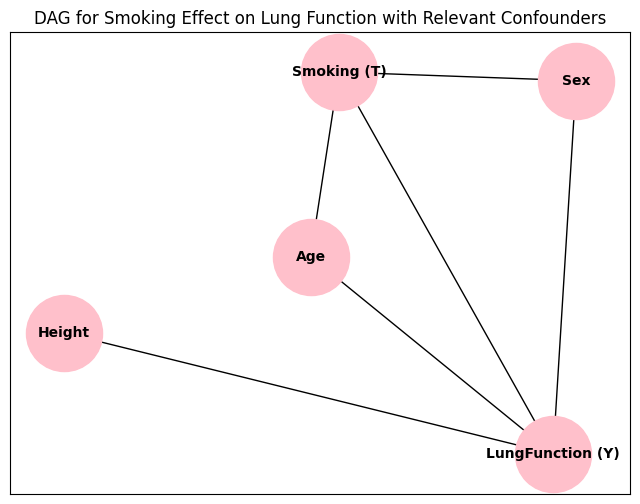

In [81]:
Graph1 = nx.DiGraph()
Graph1.add_nodes_from(['Smoking (T)', 'LungFunction (Y)', 'Age', 'Height', 'Sex'])

# Añadir arcos (relaciones causales) de acuerdo a lo que especificaste
Graph1.add_edges_from([
    ("Age", "Smoking (T)"),           # Age afecta a Smoking
    ("Age", "LungFunction (Y)"),      # Age afecta a LungFunction
    ("Sex", "Smoking (T)"),           # Sex afecta a Smoking
    ("Sex", "LungFunction (Y)"),      # Sex afecta a LungFunction
    ("Height", "LungFunction (Y)"),   # Height solo afecta a LungFunction
    ("Smoking (T)", "LungFunction (Y)")   # Smoking afecta a LungFunction
])

# Dibujar el DAG completo
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(Graph1, seed=42)  # Utilizamos spring_layout para un diseño limpio

# Dibujar nodos
nx.draw_networkx_nodes(Graph1, pos, node_size=3000, node_color="pink")
nx.draw_networkx_edges(Graph1, pos, edgelist=Graph1.edges, arrowsize=20)
nx.draw_networkx_labels(Graph1, pos, font_size=10, font_weight="bold")

# Título del gráfico
plt.title("DAG for Smoking Effect on Lung Function with Relevant Confounders")
plt.show()

In [82]:
# Age: It is a confounder that should be controlled because it affects both the likelihood of smoking and lung function.
# Sex: It is also a confounder, as it influences both the likelihood of smoking and lung function, making it essential to include as a control variable.
# Height: Although it does not affect smoking, it has a direct impact on lung function. Controlling for this variable can help reduce variability in estimating the effect of smoking on lung function.

* You are trying to study the effect of breast feeding in the number of infections a baby is likely to
have. Your dataset contains the following variables : (5 pts)

i. Breast fed (Treatment)

ii. Number of infections of the baby (Outcome)

iii. Marital status

iv. Family income

v. Education

vi. Number of children in the house

vii. Childcare outside the home

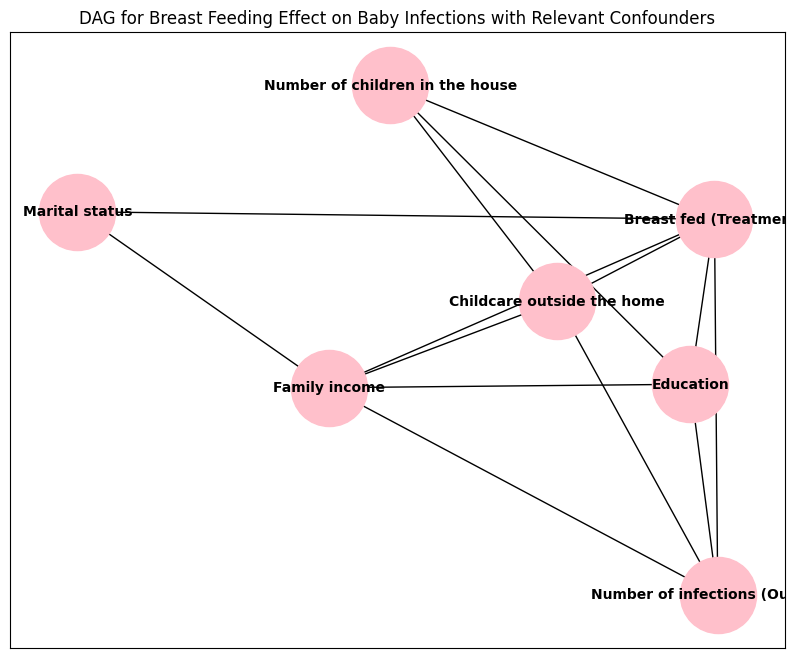

In [83]:
Graph2 = nx.DiGraph()

Graph2.add_nodes_from([
    'Breast fed (Treatment)', 
    'Number of infections (Outcome)', 
    'Marital status', 
    'Family income', 
    'Education', 
    'Number of children in the house', 
    'Childcare outside the home'
])

# Causal relations
Graph2.add_edges_from([
    ("Breast fed (Treatment)", "Number of infections (Outcome)"),          # Breast fed afecta a las infecciones
    ("Marital status", "Breast fed (Treatment)"),                          # Marital status afecta a Breast fed
    ("Marital status", "Family income"),                                   # Marital status afecta a Family income
    ("Family income", "Breast fed (Treatment)"),                           # Family income afecta a Breast fed
    ("Family income", "Number of infections (Outcome)"),                   # Family income afecta a las infecciones
    ("Family income", "Childcare outside the home"),                       # Family income afecta a Childcare outside
    ("Education", "Breast fed (Treatment)"),                               # Education afecta a Breast fed
    ("Education", "Number of infections (Outcome)"),                       # Education afecta a las infecciones
    ("Education", "Family income"),                                        # Education afecta a Family income
    ("Number of children in the house", "Education"),                      # Número de niños afecta a la Education
    ("Number of children in the house", "Breast fed (Treatment)"),         # Número de niños afecta a Breast fed
    ("Childcare outside the home", "Breast fed (Treatment)"),              # Childcare outside afecta a Breast fed
    ("Childcare outside the home", "Number of infections (Outcome)"),      # Childcare outside afecta a las infecciones
    ("Childcare outside the home", "Number of children in the house")      # Childcare outside afecta al número de niños
])


plt.figure(figsize=(10, 8))
pos = nx.spring_layout(Graph2, seed=42)  # Utilizamos spring_layout para un diseño limpio

nx.draw_networkx_nodes(Graph2, pos, node_size=3000, node_color="#FFC0CB")  # Color rosado claro
nx.draw_networkx_edges(Graph2, pos, edgelist=Graph2.edges, arrowsize=20)
nx.draw_networkx_labels(Graph2, pos, font_size=10, font_weight="bold")
plt.title("DAG for Breast Feeding Effect on Baby Infections with Relevant Confounders")
plt.show()


Confounders:
Marital Status: Marital status is a confounder because it affects both breastfeeding (the treatment) and family income. Since marital status influences these two variables, it introduces bias if not controlled for. It creates a spurious relationship between the treatment and outcome, so we need to control for it in our analysis.

Family Income: Family income also acts as a confounder because it is influenced by marital status and education, and in turn, it affects both breastfeeding and the number of infections. Not controlling for family income would result in confounding, as it would distort the true relationship between breastfeeding and the number of infections.

Education: Education influences breastfeeding, the number of infections, and family income. It is a confounder because it affects both the treatment and the outcome. If we do not account for education, we may overestimate or underestimate the effect of breastfeeding on infections.

Number of Children in the House: The number of children in the house influences both education and breastfeeding. It is another confounder that could distort the relationship between breastfeeding and the number of infections, so we must control for it.

Childcare Outside the Home: Childcare outside the home is influenced by breastfeeding and the number of infections. As it affects both the treatment and the outcome, it is also a confounder.

Family Income and Childcare Outside the Home could potentially seem like colliders because they are influenced by multiple factors. However, they are better understood as confounders in this context. Family income, for instance, is a variable that influences both breastfeeding and infections, rather than being the result of them. Similarly, childcare outside the home is more of a confounder because it is influenced by breastfeeding and infections and in turn affects the outcome.

Conclusion:
Confounders in this model include Marital Status, Family Income, Education, Number of Children in the House, and Childcare Outside the Home, because they affect both the treatment (Breastfeeding) and the outcome (Number of Infections).
There are no colliders in this analysis. Each variable either acts as a confounder or is directly related to the treatment or outcome without creating a collider effect. Therefore, controlling for the confounders mentioned is essential to properly estimate the effect of breastfeeding on the number of infections.